# Advanced Statistic -- Exercize Sheet 3

Valente Alessandro 1234429


## Ex 3.1
The time it takes a student to complete a TOLC-I University orientation and evaluation test follows
a density function of the form

$
f(X) = \begin{cases}
c(t − 1)(2 − t)\quad\, 1 < t < 2 \\
0\qquad\qquad\qquad \text{otherwise}
\end{cases}
$

where t is the time in hours.

**a)** Using the integrate() R function, determine the constant c (and verify it analytically)

The analytical computation for the constant can be done by integrating the PDF in it's domain and imposing it to be normalized to 1

$
1=\int_1^2 f(X)  =  \int_1^2 c(t-1)(2-t) \\
\qquad\qquad\,\,\, = -c[\frac{t^3}{3}-\frac{3t^2}{2}+2t]_1^2 = \frac{c}{6} \\
\implies c=6
$

In [1]:
integ <- integrate(function (x) {
            (x-1)*(2-x)}, lower=1, upper=2)
c_integ <- 1/integ$value
c_analytical <- 6

print("Integral result: ")
print(integ)
print(paste("c value by integration", c_integ))
print(paste("c value analytically  ", c_analytical))

[1] "Integral result: "
0.1666667 with absolute error < 1.9e-15
[1] "c value by integration 6"
[1] "c value analytically   6"


As we can see the agreement between the analytical and integral computation is perfect

**b)** Write the set of four R functions and plot the pdf and cdf, respectively

Since we know the normalization constant we can easily write the functions to compute the PDF and the CDF, which is the integral of the PDF, to be more specific given a particular value the 2 functions will compute the quantities

$
f(X)= c(t − 1)(2 − t) \\
F(X<=x)= \int_1^x f(X) = -2x^3+9x^2-12x+5
$

In [2]:
dtime <- function (x){
    #with ifelse i check the domain
    ifelse(x>=1 & x<=2,6*(x-1)*(2-x),0)
}

ptime <- function (x){
    #in the CDF i need a nested ifelse since the values out of the "domain"
    #are 0 at the "left" and 1 at the right, in this way it is more consistent
    ifelse(x>=1 & x<=2,-x*(2*x*x-9*x+12)+5, 
           ifelse(x>2, 1, 0))
}

We can now plot the 2 fucntions:

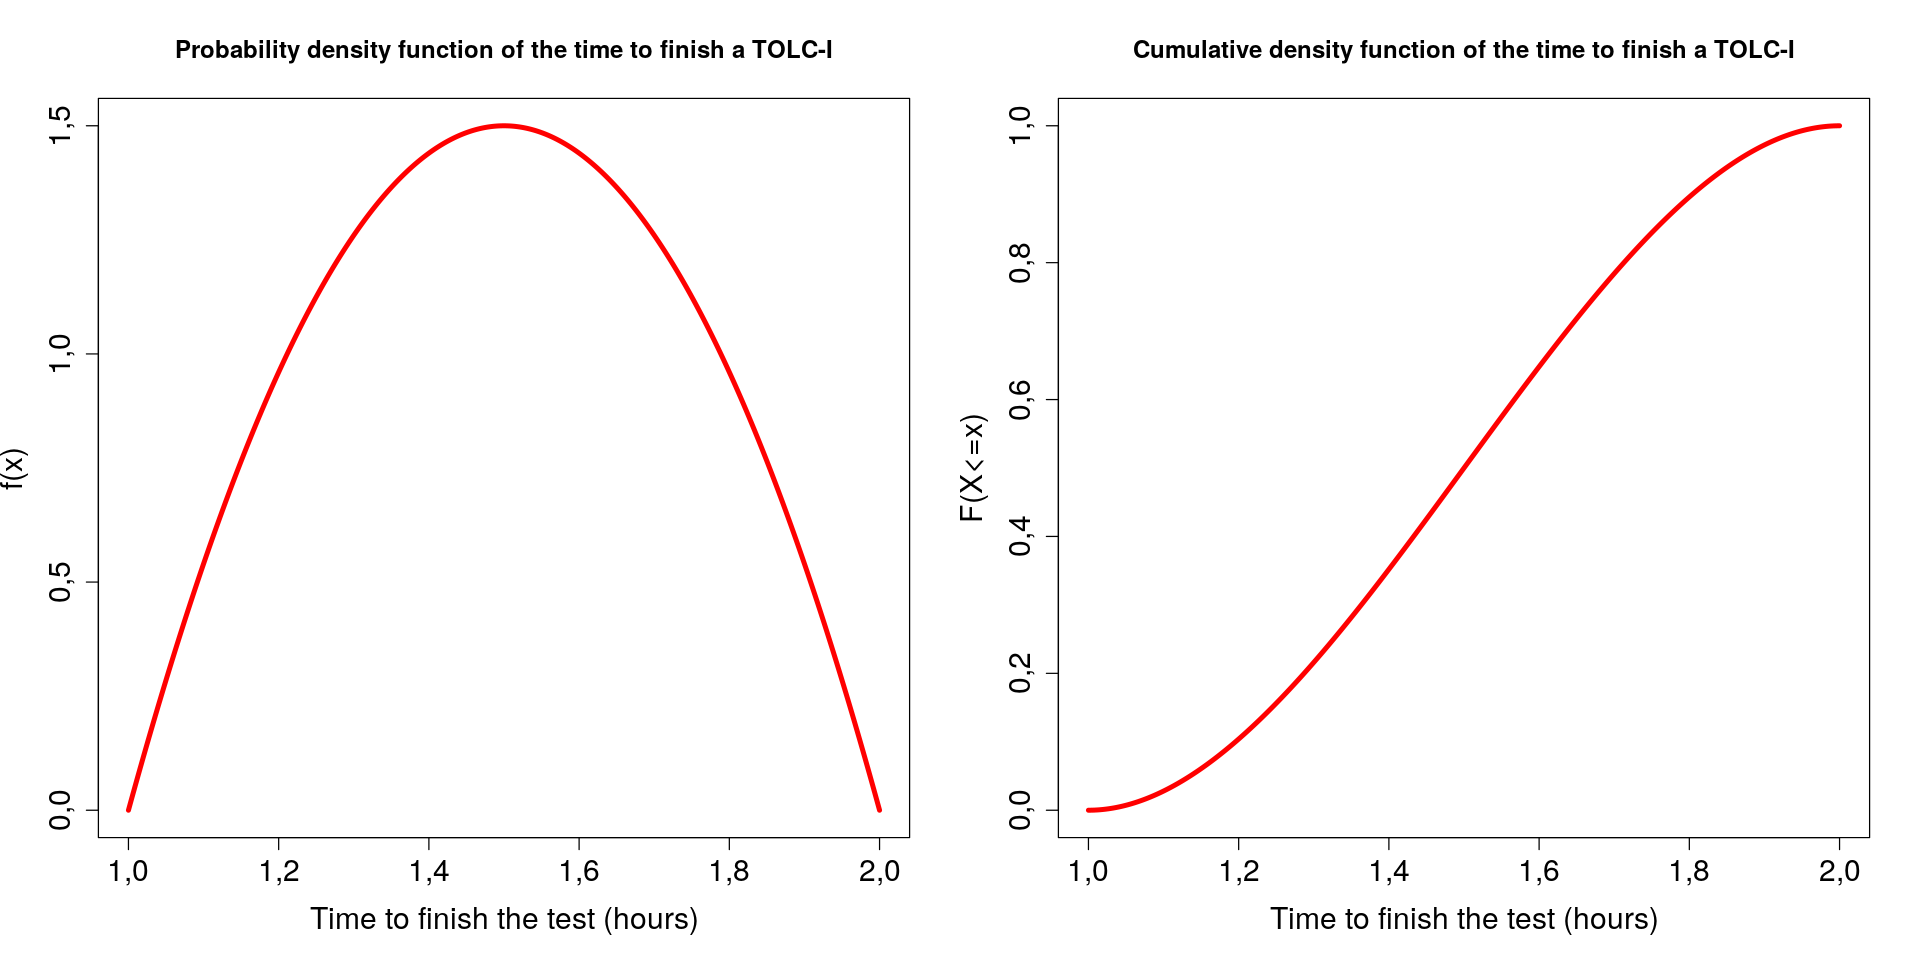

In [3]:
options(repr.plot.width=16, repr.plot.height=8)
area <- matrix (c(1,2), nrow=1, ncol=2, byrow=TRUE)
layout(area)


x <- seq(1,2,0.001)
plot(x, dtime(x), cex.lab=1.5, cex.axis=1.5, type = "l" ,  
     lwd=4, col='red', xlim=c(1,2), xlab="Time to finish the test (hours)", ylab="f(x)", main="Probability density function of the time to finish a TOLC-I")
plot(x, ptime(x), cex.lab=1.5, cex.axis=1.5, type = "l" ,  
     lwd=4, col='red', xlim=c(1,2), xlab="Time to finish the test (hours)", ylab="F(X<=x)", 
     main="Cumulative density function of the time to finish a TOLC-I")

The quantile function needs more works compared to the others since the CDF is not easily invertible, therefore the best way to compute it is in a numerical way.

In the code below i defined 2 functions:
- **qtime**: which recive as input the quantile we want to compute and serve as control function: since the input must be between 0 and 1 if the value does not respect this condition NA is returned, if it does the second function is called passing the quantile received as parameter
- **qtime_safe**: this function recive the value from ***qtime*** in this way it is sure to be between 0 and 1, in this function the position corrisponding to the quantile recived is computed using a procedure similar to the bisection method for the root finding

In the code below i defined 2 "flag" quantities:
- **eps** which represents the precision at which we can cosider to have found the correct estimation
- **n_max** maximum number of iteration for the algorithm to avoid excessive computational work

We will says something more about those parameters afterwards since they are related to the computational weight of the algorithm.

The algorithm follows this steps:
1. At the start 3 positions are defined: the left and right bound (l_bound and r_bound) and the position for the computation (pos), they are inizialized respectively as the extreme points of the domain and the center of the domain
2. the CDF at the position pos is computed
2. if the difference between the CDF at that position and the quantile recived is less that the precision eps it returns that position and stops
3. if not it updates the bounds and position in this way:
    - if the recived quantile is less than the CDF computed value the right bound  gets updated with the computation position
    - if the recived quantile is bigger than the CDF computed value the left bound  gets updated with the computation position
    - the computation position gets updated as the middle point between the bounds
4. if the number of iterations is less than n_max restart from point 2
5. if not return the CDF value at the updated position


Once the quantile function is defined the sampling function can be defined by making it return the quantile of a certain number of uniformly generated points

In [4]:
eps <- 10^(-7)
n_max <- 20


qtime_safe <- function(x){
    iter <- 0
    l_bound <-1
    r_bound <-2
    pos <- 1.5
    while (iter <n_max){
        #print(paste("start", iter, pos, old_pos))
        q  <- ptime(pos)
        lq <- ptime(l_bound)
        rq <- ptime(r_bound)
        if (abs(q-x) < eps) return(pos)
        else { 
            ifelse(x<q, r_bound <- pos, l_bound <- pos)
            pos <- (r_bound+l_bound)/2
            iter <- iter +1
        }
    }
    return (pos)
}
qtime <- function (xs){
    quants <- vector('numeric', length(xs))
    for (i in 1:length(xs))quants[[i]]<- ifelse(xs[i]>=0 & xs[i]<=1, qtime_safe(xs[i]), NA)
    return(quants)
}

rtime <- function (n){
    return(qtime(runif(n)))
}

To check the efficiency of this algorithm and it's correct functioning we can make an histogram of samples from the distribution then overimposing the PDF multiplied by the area of the histogram 

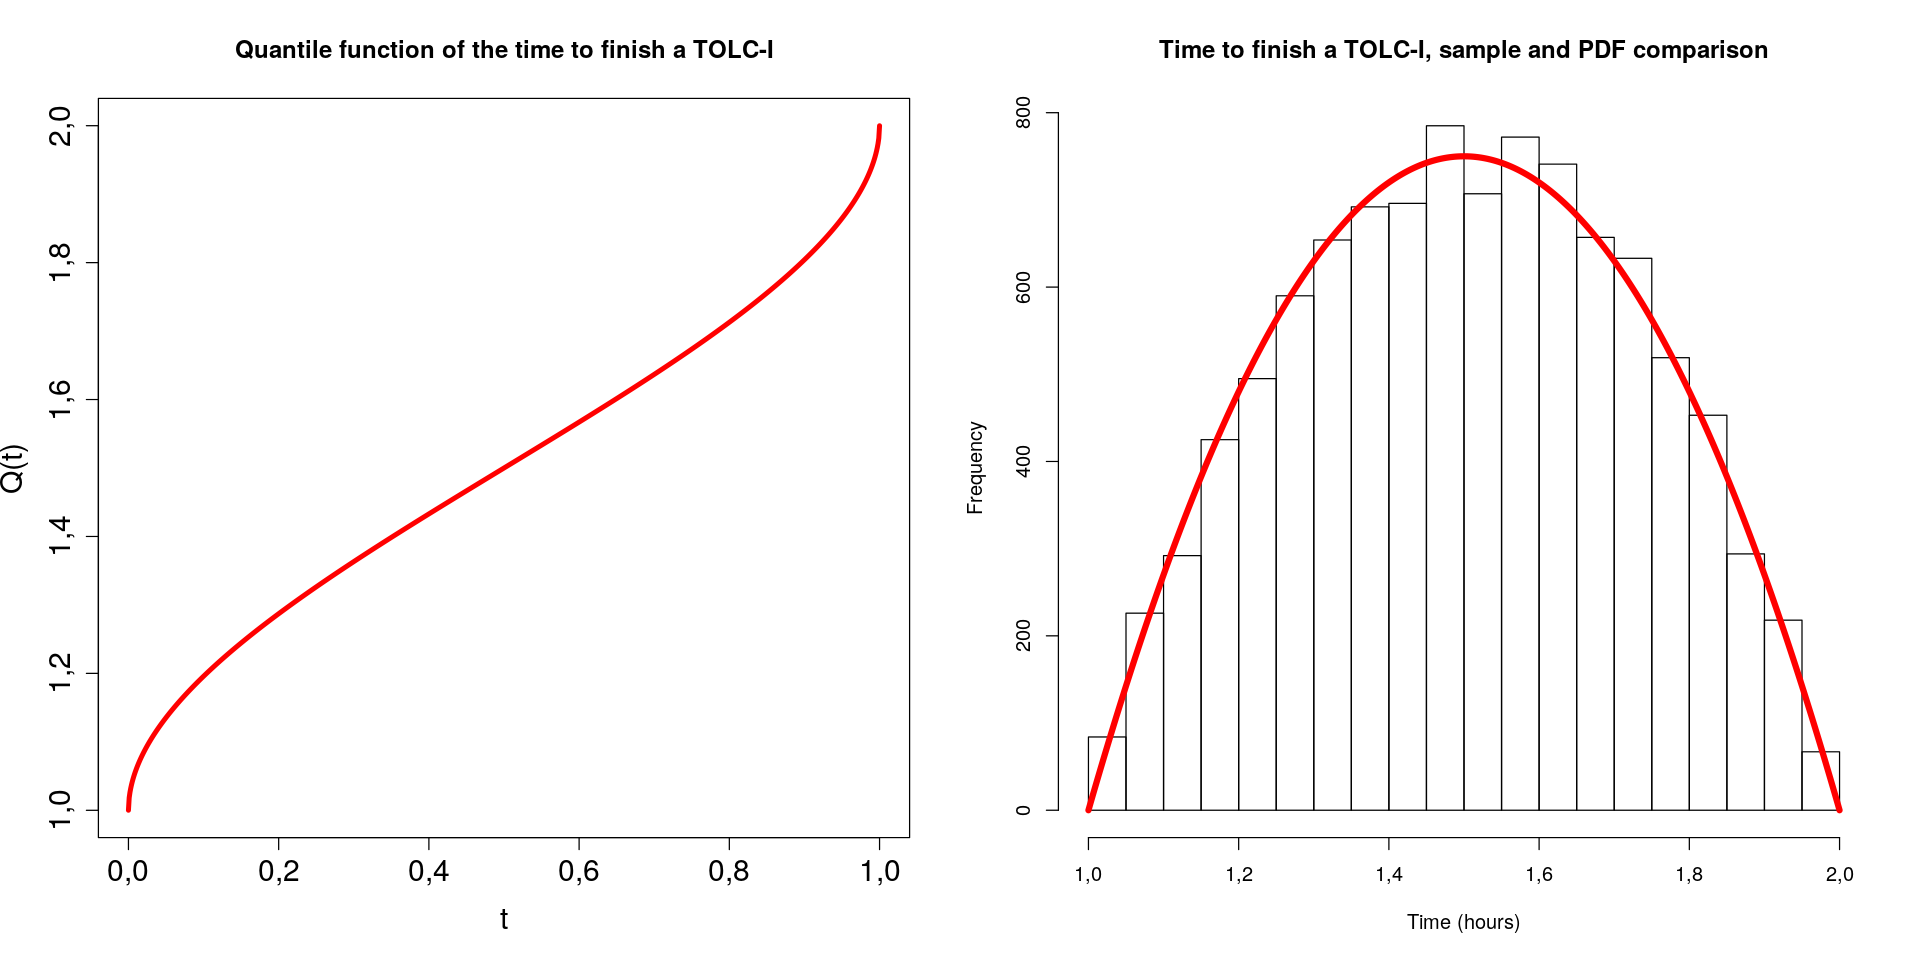

In [5]:
options(repr.plot.width=16, repr.plot.height=8)
area <- matrix (c(1,2), nrow=1, ncol=2, byrow=TRUE)
layout(area)

x <- seq(0,1,0.001)
plot(x, qtime(x), cex.lab=1.5, cex.axis=1.5, type = "l" ,  
     lwd=4, col='red', xlim=c(0,1), xlab="t", ylab="Q(t)", main="Quantile function of the time to finish a TOLC-I")
asd<- seq(1,2, 0.001)
nb <- 30
h <- hist(rtime(10000),xlim=c(1,2), breaks=nb, main="Time to finish a TOLC-I, sample and PDF comparison", xlab="Time (hours)")
#the normalization area is the mean of the counts per bin
#this is because the bin have all the same size and the interval is one
#otherwise i should have summed each bin value multiplied by the bin width
area <- mean(h$counts) 
lines(asd, dtime(asd)*area, lwd=5, col='red')

As we can see the histogramm is well represented by the PDF.
An alternative way of computing the quantile would have been just computing the CDF is a linear sequance of point and returning teh closest one but this algorithm is moreconvenient since it has two important properties:
- it is gauranteed to converge since the CDF is continuous
- it has a really fast computation due to it's nature in fact since the width of the interval is halved at each iteration we can compute the number of maximum iterations to converge as

$ n=log_2\left( \frac{b-a}{eps}\right) $

where b and a are the extrems of the domain and eps our precision.
As we can see before we asked for a eps=$10^{-7}$ precision so the maximum numbers of iteration to converge are:

$ n_{max}= \log_2 \left( \frac{1}{10^{-7}} \right) = 24 $

**c)** evaluate the probability that the student will finish the aptitude test in more than 75 minutes. And
that it will take (between?) 90 and 120 minutes.

The first probability can be derived from the CDF as

$ P(X>75) =1- P(X<=75) = 1- CDF(75)$

The second one can be compute from the CDF as well:

$ P(90< X<= 120) = P(X<=120) -P(X<=90) =CDF(120)-CDF(90)$

In [6]:
p75 <- 1-ptime(1.25) #time in hours
p90 <- ptime(2)-ptime(1.5)

print(paste("Prob of finishing in more than 75 mins:", round(p75,3)))
print(paste("Prob of finishing in 90~120 mins:", p90))

[1] "Prob of finishing in more than 75 mins: 0,844"
[1] "Prob of finishing in 90~120 mins: 0,5"


## Ex 3.2
The lifetime of tires sold by an used tires shop is $10^4\cdot x$km, where x is a random variable following the distribution funcion:

$ 
f(X) = 
\begin{cases}
\frac{2}{x^2}\quad 1 < x < 2 \\
0 \qquad \text{otherwise }
\end{cases} 
$

**a)** write the set of four R functions and plot the pdf and cdf, respectively

The distribution is already normalized:

$ \int_1^2 \frac{2}{x^2} = \left[-\frac{2}{x}\right]_1^2 = 1 $

So we can as before directly write the PDF and CDF function which will directly compute:

$f(X) =\frac{2}{x^2} \\
F(X<=x) =\int_1^x f(X) =2-\frac{2}{x}
$

This time the CDF is easily invertible so also the quantile function can be computed analytical

$ Q(t)= CDF^{-1}(t) = \frac{2}{2-t} $

In [7]:
dlifetime <- function(x){
    ifelse(x>=1 & x<=2, 2/(x^2),0)
}
plifetime <- function(x){
    ifelse(x>=1 & x<=2, 2-2/x, ifelse(x<1,0,1))
}
qlifetime <- function(x){
    ifelse(x>=0 & x<=1, 2/(2-x),0)
}
rlifetime <- function(n){
    return (qlifetime(runif(n)))
}

We can then plot the PDF and CDF

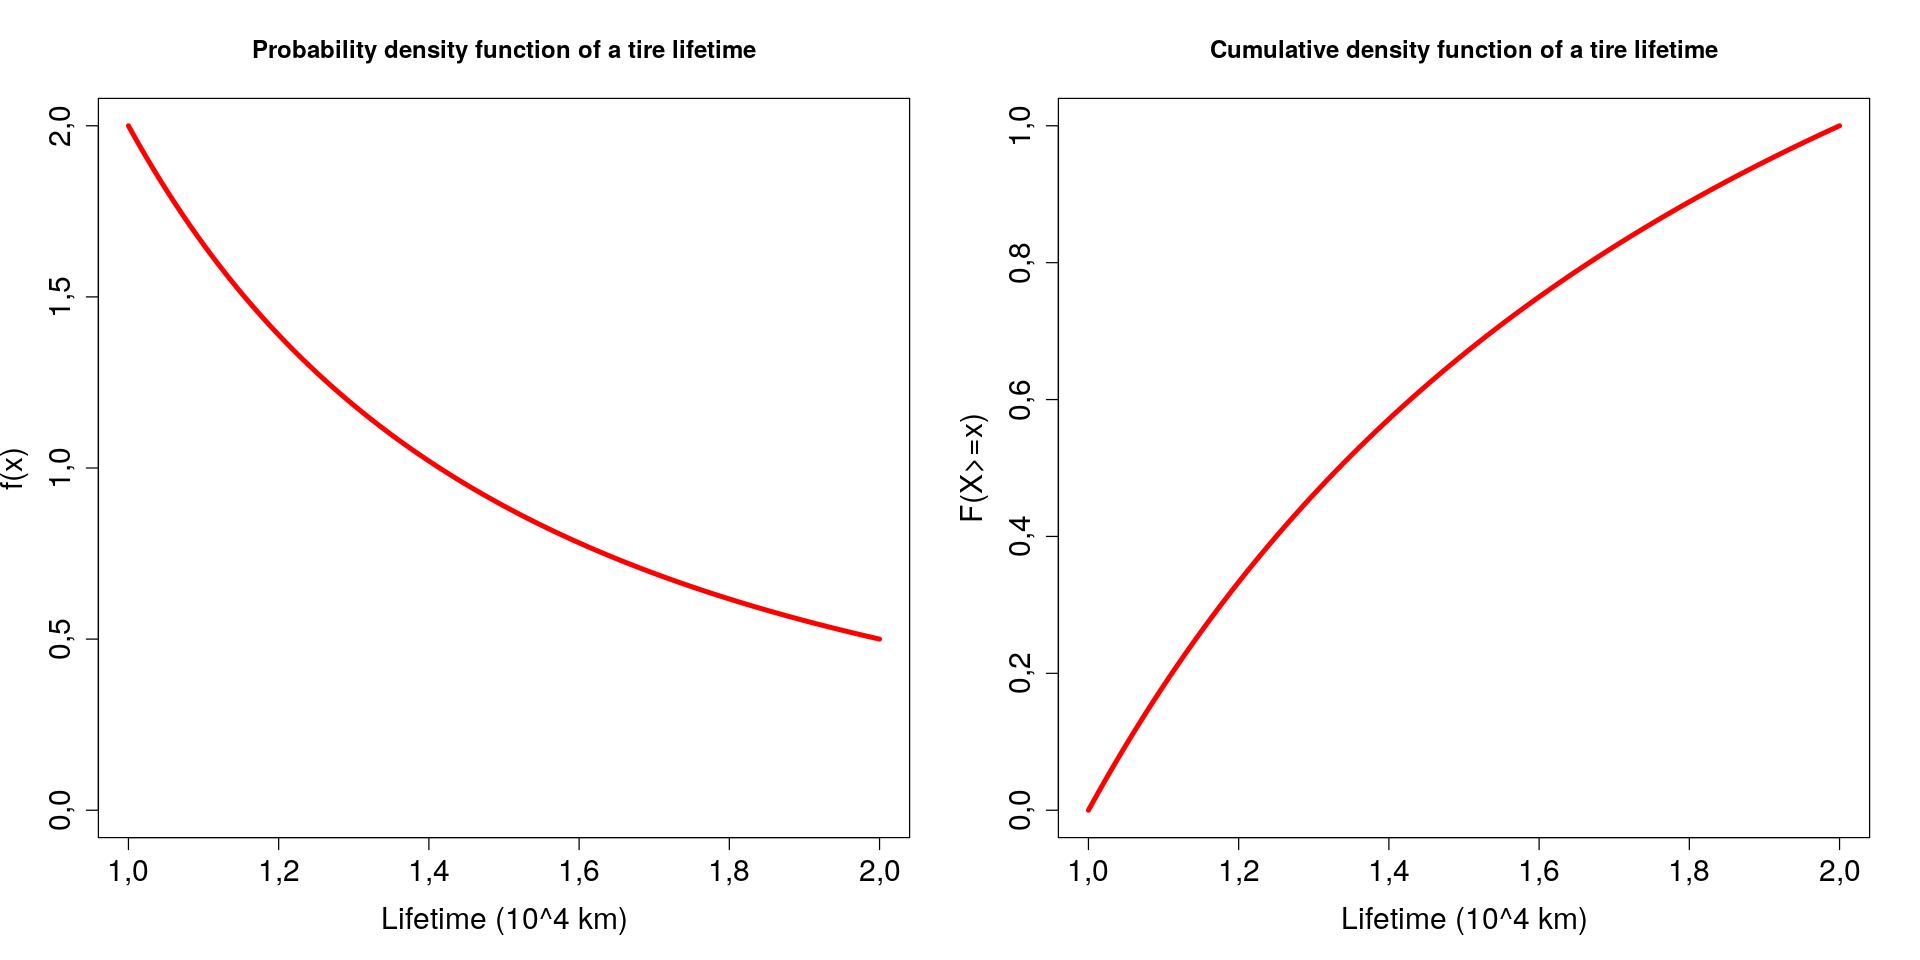

In [8]:
options(repr.plot.width=16, repr.plot.height=8)
area <- matrix (c(1,2), nrow=1, ncol=2, byrow=TRUE)
layout(area)

x <- seq(1,2,0.001)
plot(x, dlifetime(x), cex.lab=1.5, cex.axis=1.5, type = "l" , 
     lwd=4, col='red', xlim=c(1,2), ylim=c(0,2), xlab="Lifetime (10^4 km)", ylab="f(x)", 
     main="Probability density function of a tire lifetime")
plot(x, plifetime(x), cex.lab=1.5, cex.axis=1.5, type = "l" , 
     lwd=4, col='red', xlim=c(1,2), xlab="Lifetime (10^4 km)", ylab="F(X>=x)", 
     main="Cumulative density function of a tire lifetime")


**b)** determine the probability that tires will last less than 15000 km

This probability can be directly computed using the CDF function

In [9]:
p_under15 <- plifetime(1.5)
print(paste("Probability of lasting less that 15000 km :", round(p_under15, 3)))

[1] "Probability of lasting less that 15000 km : 0,667"


**c)** sample 3000 random variables from the distribution and determine the mean value and the variance,
using the expression 

$Var(X) = E[X^2] − E[X]^2$

In [10]:
#let's define the functions for mean and variance
mean <- function(x){
    n <- length(x)
    return (sum(x)/n)
}
var <- function(x){
    n<- length(x)
    return (sum(x*x)/n - (sum(x)/n)^2)
}

The results from the previous functions will be verified analytically by the following calculations:

$
E[X]=\int_1^2 x\cdot\frac{2}{x^2}=2\ln |x| ]_1^2 =2\ln 2\\
E[X^2]=\int_1^2 x^2\cdot\frac{2}{x^2} =2x]_1^2=2\\
var(X)=E[X^2]-E[X]^2=2-(2\ln 2)^2
$

In [11]:
n <- 3000
lifes <- rlifetime(n)

mean_life <- mean(lifes)
var_life <- var(lifes)

mean_life_calc <- 2*log(2)
var_life_calc  <- 2- (2*log(2))^2

print(paste("Mean value by sampling    :",round(mean_life,3)))
print(paste("Mean value by calculation :",round(mean_life_calc,3)))
print(paste("Variance by sampling      :",round(var_life,3)))
print(paste("Variance by calculation   :",round(var_life_calc,3)))

[1] "Mean value by sampling    : 1,382"
[1] "Mean value by calculation : 1,386"
[1] "Variance by sampling      : 0,079"
[1] "Variance by calculation   : 0,078"


As we can see there is a good agreement between the theoretical and computed value


## Ex 3.3
Marokov’s inequality represents an upper boud to probability distributions:

$
P(X ≥ k) ≤
\frac{E[X]}{k}\,\,\text{for }k > 0 $

Having defined a function

$G(k) = 1 − F(k) ≡ P(X ≥ k)$

plot G(k) and the Markov’s upper bound for

**a)** the exponential, Exp(λ = 1), distribution function


For the exponential distribution:

$ E[X] =\frac{1}{\lambda} $

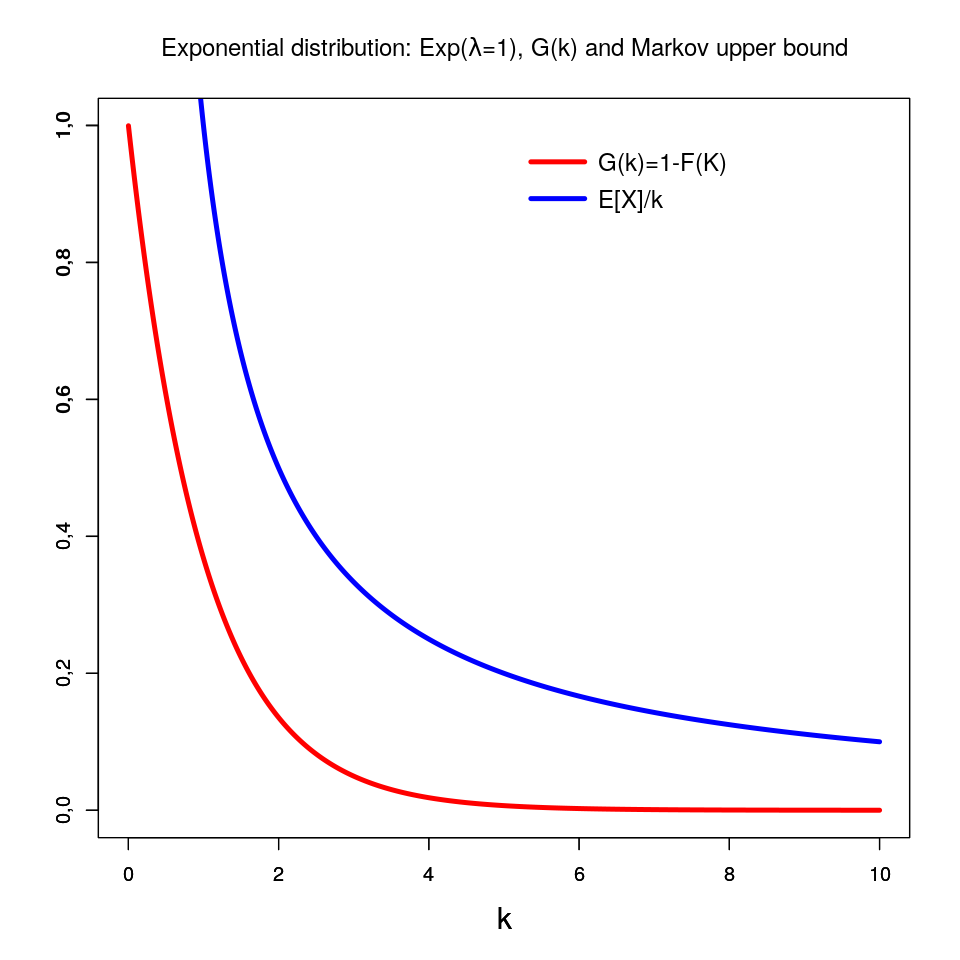

In [12]:
options(repr.plot.width=8, repr.plot.height=8)

lambda <-1
ex <- 1/lambda

k <- seq(0.001, 10, 0.001)
plot(k, ex/k, type='l', ylim=c(0,1), lwd=4, col='blue', xlab='k', ylab='', cex.lab=1.5,
     main=expression(paste("Exponential distribution: Exp(", lambda, "=1), G(k) and Markov upper bound")))  
par(new=TRUE)
plot(k, 1-pexp(k, lambda), type='l', lwd=4, col='red',  xlab='k', ylab='', cex.lab=1.5)
#par(xpd=TRUE)
legend(5,1, legend=c("G(k)=1-F(K)", "E[X]/k"), col=c('red', 'blue'),  lty=1, lwd=4, bty='n', x.intersp = 0.5, cex=1.2, text.width = 1.3)


**b)** the uniform, U(3, 5), distribution function


For the uniform distribution:

$ E[X] = \frac{b+a}{2} $

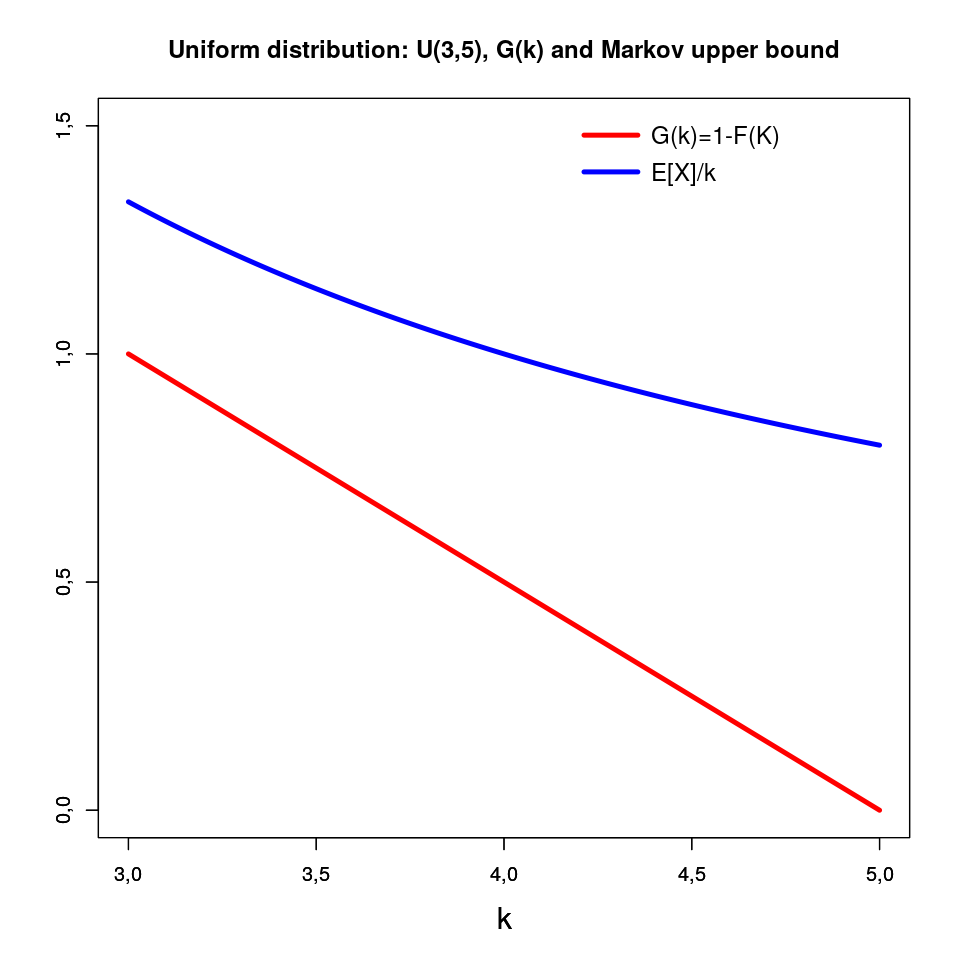

In [13]:
options(repr.plot.width=8, repr.plot.height=8)

a <-3
b <-5
ex <- (b+a)/2
k <- seq(a, b, 0.001)
plot(k, ex/k, type='l', ylim=c(0,1.5), lwd=4, col='blue', xlab='k', ylab='', cex.lab=1.5,
     main="Uniform distribution: U(3,5), G(k) and Markov upper bound")  
par(new=TRUE)
plot(k, 1-punif(k, a,b), type='l',ylim=c(0,1.5), lwd=4, col='red',  xlab='k', ylab='', cex.lab=1.5)
#par(xpd=TRUE)
legend("topright", inset=c(-0.3,0), legend=c("G(k)=1-F(K)", "E[X]/k"), col=c('red', 'blue'), 
       lty=1, lwd=4, bty='n', x.intersp = 0.5, cex=1.2, text.width = 1.3)


**c)** the binomial, Bin(n = 1, p = 1/2), distribution function


For the binomial distribution: 

$ E[X] = np $

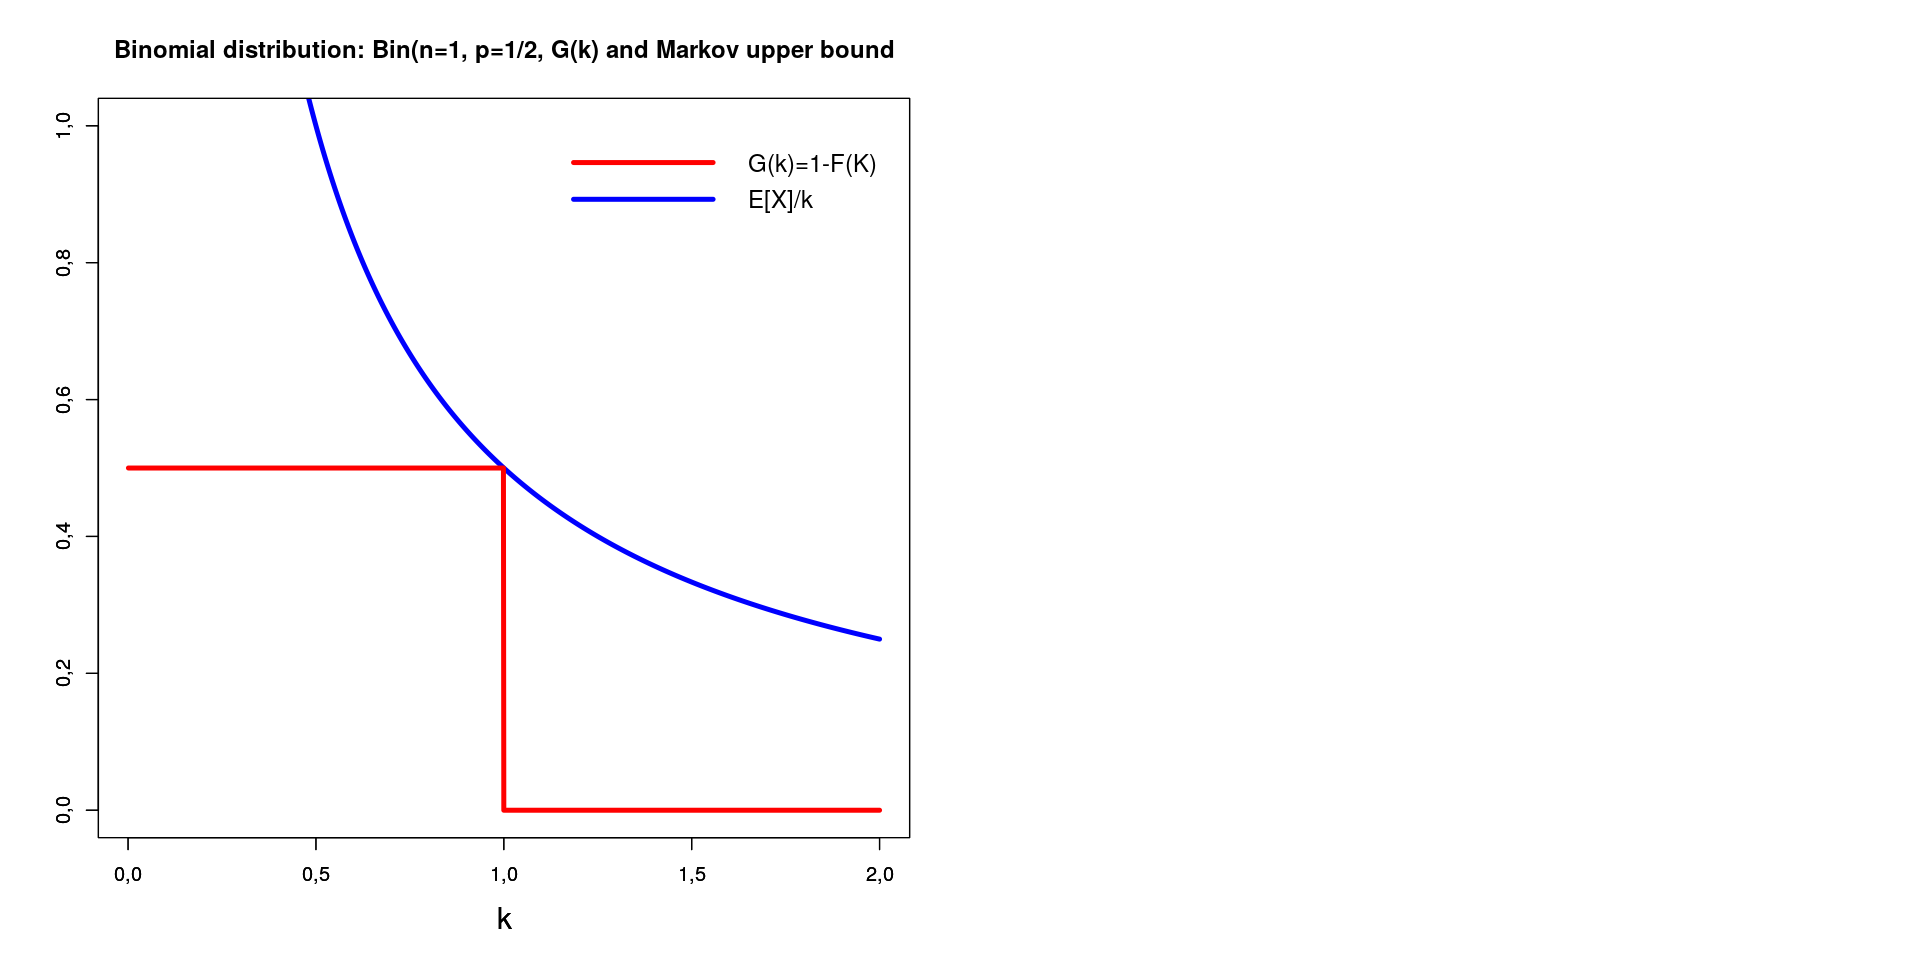

In [14]:
options(repr.plot.width=16, repr.plot.height=8)
area <- matrix (c(1,2), nrow=1, ncol=2, byrow=TRUE)
layout(area)

N <-1
p<- 1/2
ex <- N*p

k <- seq(0.001, 2, 0.001)
plot(k, ex/k, type='l', ylim=c(0,1), lwd=4, col='blue', xlab='k', ylab='', cex.lab=1.5,
     main="Binomial distribution: Bin(n=1, p=1/2, G(k) and Markov upper bound")  
par(new=TRUE)
plot(k, 1-pbinom(k,N,p), type='l', ylim=c(0,1), lwd=4, col='red',  xlab='k', ylab='', cex.lab=1.5)
#par(xpd=TRUE)
legend(1,1, legend=c("G(k)=1-F(K)", "E[X]/k"), col=c('red', 'blue'),  lty=1, lwd=4, bty='n', x.intersp = 0.5, cex=1.2, text.width = 1.3)


**d)** a Poisson, Pois(λ = 1/2), distribution function

For the poisson distribution: 

$ E[X] = \lambda $

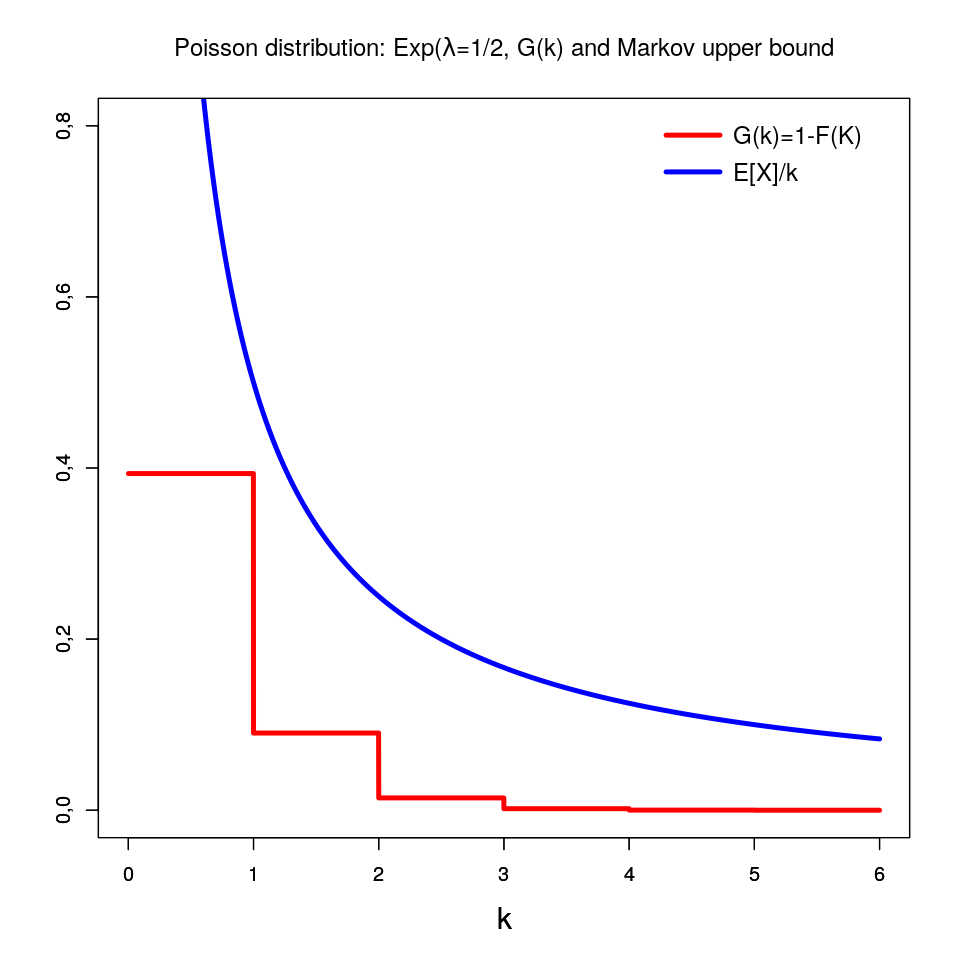

In [15]:
options(repr.plot.width=8, repr.plot.height=8)

lambda <-1/2
ex <- lambda

k <- seq(0.001, 6, 0.001)
plot(k, ex/k, type='l', ylim=c(0,0.8), lwd=4, col='blue', xlab='k', ylab='', cex.lab=1.5,
     main=expression(paste("Poisson distribution: Exp(", lambda, "=1/2, G(k) and Markov upper bound")))  
par(new=TRUE)
plot(k, 1-ppois(k, lambda),ylim=c(0,0.8), type='l', lwd=4, col='red',  xlab='k', ylab='', cex.lab=1.5)
#par(xpd=TRUE)
legend("topright", legend=c("G(k)=1-F(K)", "E[X]/k"), col=c('red', 'blue'),  lty=1, lwd=4, bty='n', x.intersp = 0.5, cex=1.2, text.width = 1.3)


From these plots we can see that the Markov's inequality is always respected as we can see that the red line ($G(k)$) is always upper bounded by the blue one ($E[X]/k$)

## Ex 3.4

• Chebyshev’s inequality tell us that

$P(|X − µ| ≥ kσ) ≤\frac{1}{k^2} $

which can also be written as

$P(|X − µ| < kσ) ≥ 1 −\frac{1}{k^2}$

 use R to show, with a plot, that Chebyshev’s inequality is is an upper bound to the following
distributions:


If we start from the second equation we can derive the following:
$P(|X − µ| < kσ) = P(-k\sigma <X-\mu <k\sigma) = P(\mu-k\sigma <X <\mu+k\sigma) \\
                 =P(X<\mu+k\sigma) -P(X<=\mu -k\sigma)$
                 
The two terms can be computed using the CDF function:

$P(X<\mu+k\sigma) -P(X<=\mu -k\sigma)= CDF(\mu+k\sigma) -CDF(\mu-k\sigma) $


We then have to show that:

$CDF(\mu+k\sigma) -CDF(\mu-k\sigma)  >= 1-\frac{1}{k^2}$

For sake of notation we will call in the plots the functions as:

$ P(|X − µ| < kσ) = CDF(\mu+k\sigma) -CDF(\mu-k\sigma) \implies H(\mu,\sigma, k) \\
1-\frac{1}{k^2} \implies C(k) $

**a)** a normal distribution, N(µ = 3, σ = 5)


For the normal distribution $\mu$ and $\sigma$ are alredy defined as they are passed as parameters

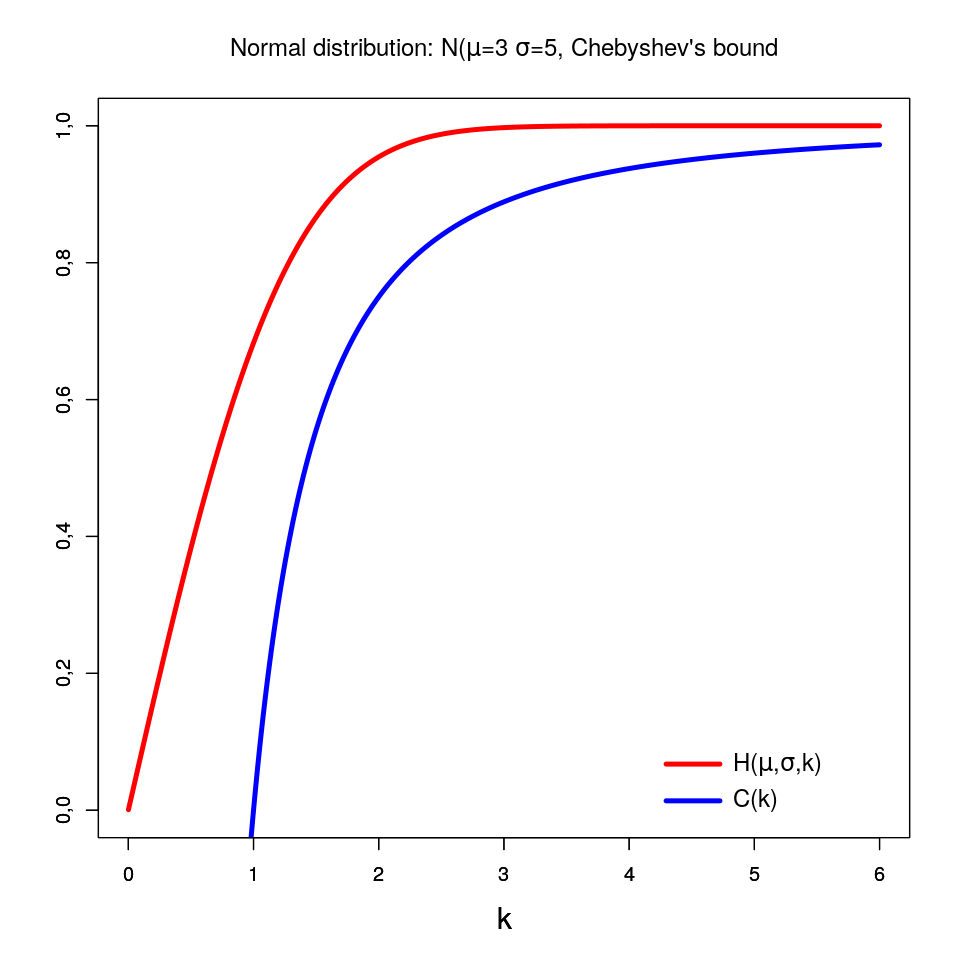

In [16]:
options(repr.plot.width=8, repr.plot.height=8)

mu <- 3
sigma <-5

k <- seq(0.001, 6, 0.001)
plot(k, 1-1/(k*k), type='l', ylim=c(0,1), lwd=4, col='blue', xlab='k', ylab='', cex.lab=1.5,
     main=expression(paste("Normal distribution: N(", mu, "=3 ", sigma, "=5, Chebyshev's bound")))  
par(new=TRUE)
plot(k, pnorm(mu+k*sigma, mu, sigma)-pnorm(mu-k*sigma, mu, sigma)  ,ylim=c(0,1), type='l', lwd=4, col='red',  xlab='k', ylab='', cex.lab=1.5)
#par(xpd=TRUE)
legend("bottomright", legend=c(expression(paste("H(",mu,",",sigma,",k)")), "C(k)"), col=c('red', 'blue'),  lty=1, lwd=4, bty='n', x.intersp = 0.5, cex=1.2, text.width = 1.3)


**b)** an exponential distribution, Exp(λ = 1)


For the exponential distribution:

$\mu = \frac{1}{\lambda} \qquad
 \sigma = \sqrt{var[X]} = \sqrt{\frac{1}{\lambda^2}} =\frac{1}{\lambda} $

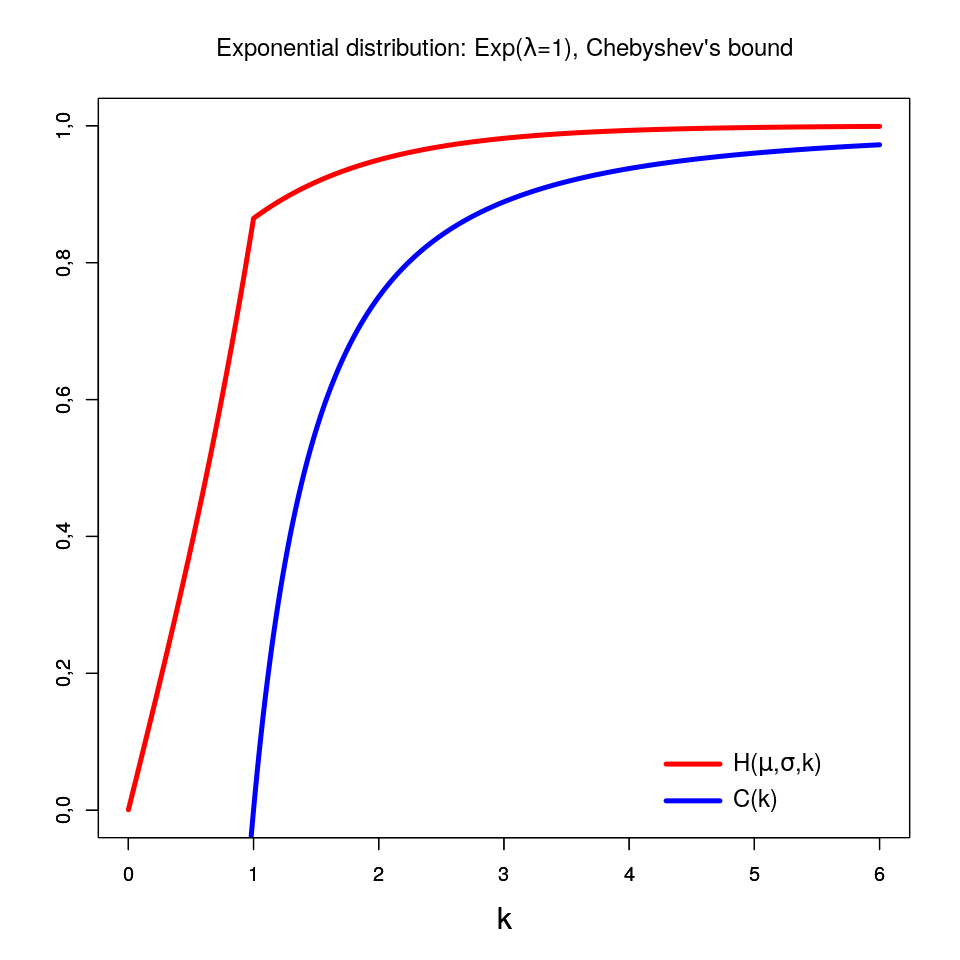

In [17]:
n <- 10^5
lambda <- 1
mu <- 1/lambda
sigma <- 1/lambda


k <- seq(0.001, 6, 0.001)
plot(k, 1-1/(k*k), type='l', ylim=c(0,1), lwd=4, col='blue', xlab='k', ylab='', cex.lab=1.5,
     main=expression(paste("Exponential distribution: Exp(", lambda, "=1), Chebyshev's bound")))  
par(new=TRUE)
plot(k, pexp(mu+k*sigma, lambda)-pexp(mu-k*sigma, lambda)  ,ylim=c(0,1), type='l', lwd=4, col='red',  xlab='k', ylab='', cex.lab=1.5)
#par(xpd=TRUE)ù
legend("bottomright", legend=c(expression(paste("H(",mu,",",sigma,",k)")), "C(k)"), col=c('red', 'blue'),  lty=1, lwd=4, bty='n', x.intersp = 0.5, cex=1.2, text.width = 1.3)



**c)** a uniform distribution U(1 − $\sqrt{2}$, 1 + $\sqrt{2}$)


For the uniform distribution:

$\mu = \frac{a+b}{2} \quad
 \sigma = \sqrt{var[X]} = \sqrt{\frac{(b-a)^2}{12}} =\frac{b-a}{\sqrt{12}} $

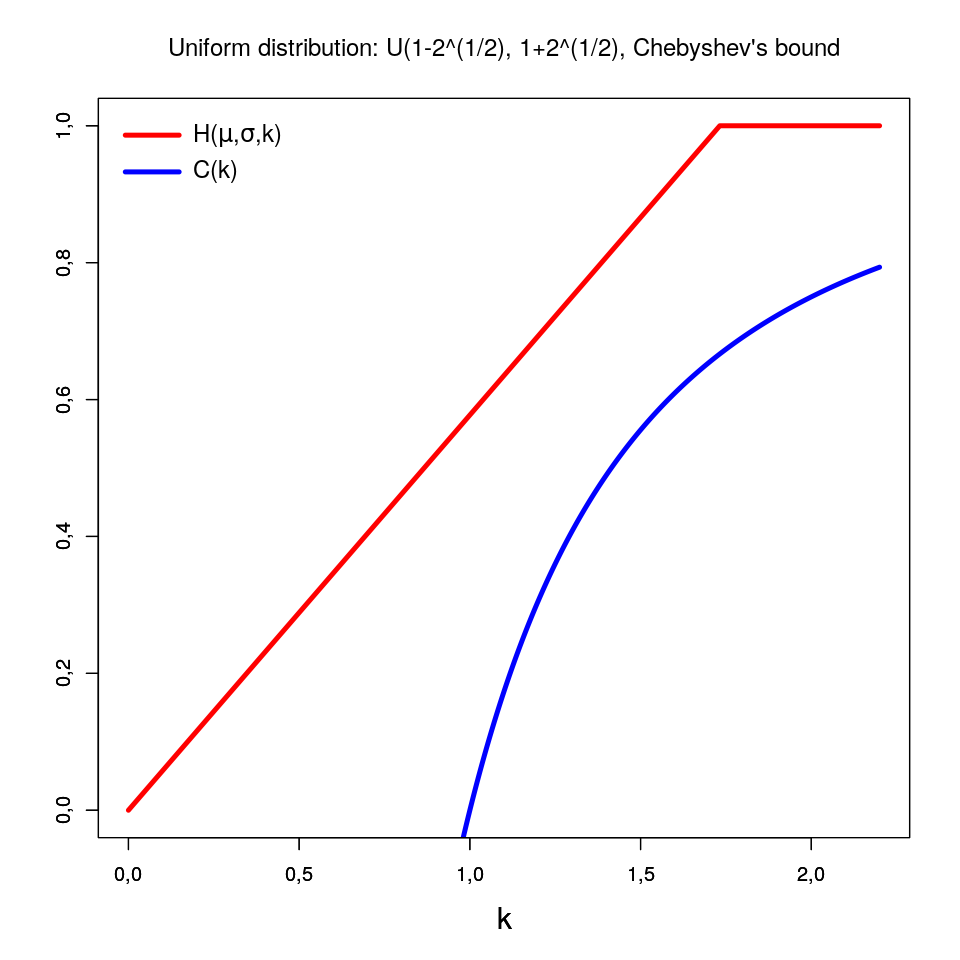

In [18]:
n <- 10^5
a <- 1 -sqrt(2)
b <- 1+sqrt(2)
mu <- (a+b)/2
sigma <- (b-a)/sqrt(12)

k <- seq(0,2.2 , 0.001)
plot(k,1-1/(k*k), type='l', ylim=c(0,1), lwd=4, col='blue', xlab='k', ylab='', cex.lab=1.5,
     main=expression(paste("Uniform distribution: U(1-2^(1/2), 1+2^(1/2), Chebyshev's bound")))  
par(new=TRUE)
plot(k, punif(mu+k*sigma, a,b)-punif(mu-k*sigma, a,b)  ,ylim=c(0,1), type='l', lwd=4, col='red',  xlab='k', ylab='', cex.lab=1.5)
#par(xpd=TRUE)ù
legend("topleft", legend=c(expression(paste("H(",mu,",",sigma,",k)")), "C(k)"), col=c('red', 'blue'),  lty=1, lwd=4, bty='n', x.intersp = 0.5, cex=1.2, text.width = 1.3)


**d)** a Poisson, Pois(λ = 1/3), distribution function

For the Poisson distribution


$\mu = \lambda \quad
 \sigma = \sqrt{var[X]} =\sqrt{\lambda} $

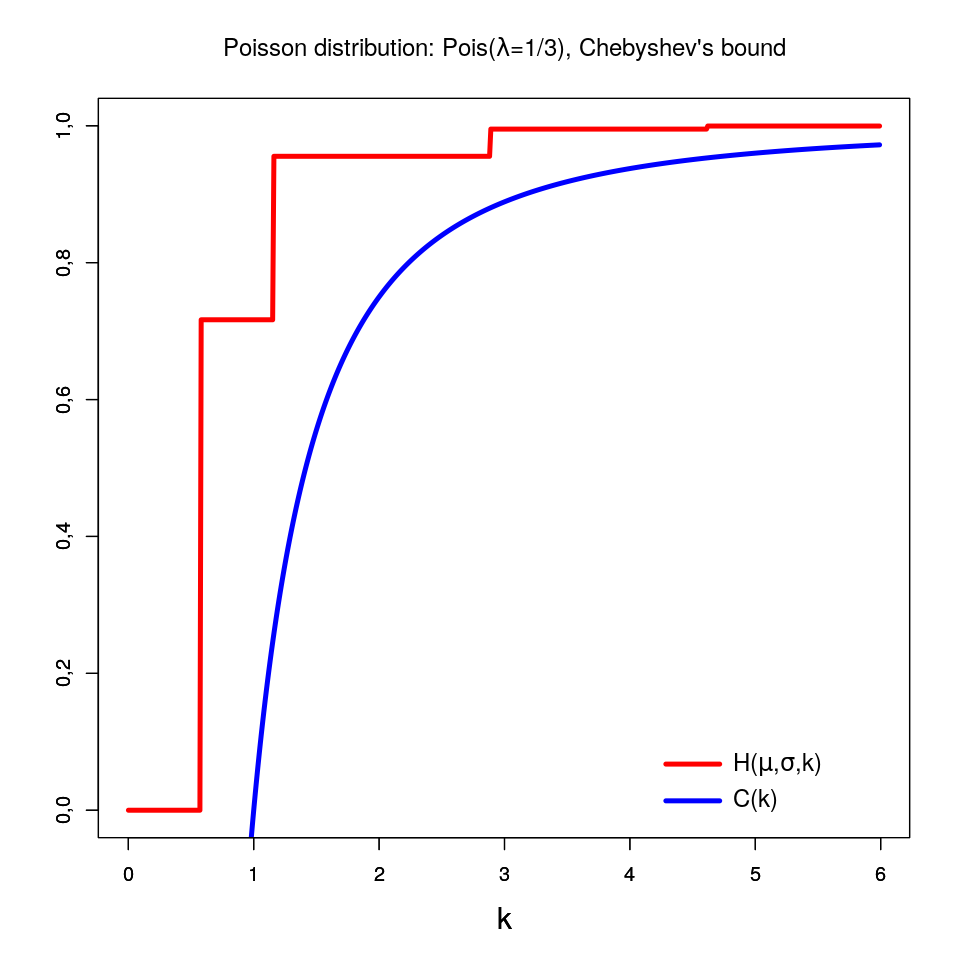

In [19]:
n <- 10^5
lambda <- 1/3
mu <- lambda
sigma <- sqrt(lambda) 


k <- seq(0.001, 6, 0.01)
plot(k, 1-1/(k*k), type='l', ylim=c(0,1), lwd=4, col='blue', xlab='k', ylab='', cex.lab=1.5,
     main=expression(paste("Poisson distribution: Pois(", lambda, "=1/3), Chebyshev's bound")))  
par(new=TRUE)
plot(k, ppois((mu+k*sigma), lambda)-ppois((mu-k*sigma), lambda),
     ylim=c(0,1), type='l', lwd=4, col='red',  xlab='k', ylab='', cex.lab=1.5)
#par(xpd=TRUE)
legend("bottomright", legend=c(expression(paste("H(",mu,",",sigma,",k)")), "C(k)"), col=c('red', 'blue'),  lty=1, lwd=4, bty='n', x.intersp = 0.5, cex=1.2, text.width = 1.3)



As we can see the Chebyshv's inequality is also always respected since in the various plot the function $P(|X − µ| < kσ)$ (red line) is always bigger respect to $1-1/k^2$ (blue line) as we wanted to show